/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


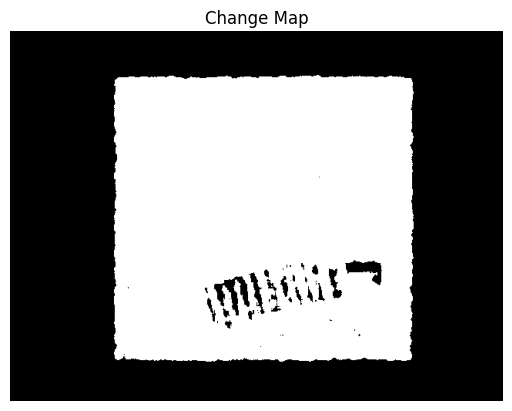

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt
from google.colab import files

def pca_kmeans(im1, im2, block_size, rate=0.9):
    # Convert images to grayscale
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Calculate image size and padding size
    image_size = im1_gray.shape
    padding_size = (image_size[0] + block_size[0] - 1, image_size[1] + block_size[1] - 1)

    # Calculate the difference image
    delta = np.abs(im1_gray.astype(float) - im2_gray.astype(float))

    # Padding
    padding_img = np.zeros(padding_size)
    lb = (block_size[0] // 2, block_size[1] // 2)
    ub_col = lb[0] + image_size[0]
    ub_row = lb[1] + image_size[1]
    padding_img[lb[0]:ub_col, lb[1]:ub_row] = delta

    # Generate feature vector for blocks
    vk = np.zeros((np.prod(image_size), np.prod(block_size)))
    cnt = 0
    for k1 in range(image_size[0]):
        for k2 in range(image_size[1]):
            vk_temp = padding_img[k1:k1+block_size[0], k2:k2+block_size[1]]
            vk[cnt,:] = vk_temp.reshape(-1)
            cnt += 1

    # Normalization
    mean_val = np.mean(vk, axis=0)
    std_val = np.std(vk, axis=0) + 1e-12
    vk = (vk - mean_val) / std_val

    # PCA
    cov = np.dot(vk.T, vk)
    val, V = np.linalg.eig(cov)
    val_sorted_indices = np.argsort(val)[::-1]
    val_sorted = val[val_sorted_indices]
    vec = V[:, val_sorted_indices[:np.argmax(np.cumsum(val_sorted) >= rate * np.sum(val_sorted)) + 1]]
    feature = np.dot(vk, vec)

    # k-Means clustering
    kmeans = KMeans(n_clusters=2)
    label = kmeans.fit_predict(feature)

    # Generate change map
    change_map = label.reshape(image_size)

    return change_map


# Load input images
im1 = cv2.imread('/content/input_image.jpeg')
im2 = cv2.imread('/content/input_image2.jpeg')

# Define block size and rate
block_size = (8, 8)  # Example block size
rate = 0.9  # Example rate

# Perform change detection
change_map = pca_kmeans(im1, im2, block_size, rate)

# Display the change map
plt.imshow(change_map, cmap='gray')
plt.title('Change Map')
plt.axis('off')
plt.show()

# Scale the change map to 0-255
change_map_scaled = (change_map * 255).astype(np.uint8)

# Save the change map as an image file
cv2.imwrite('/content/yellowRiver_change_map.jpg', change_map_scaled)

# Provide download link for the change map
files.download('/content/yellowRiver_change_map.jpg')
